# APPLE Earnings Transcript Scraper (FY2022-2025)

This notebook scrapes earnings call transcripts for APPLE (FY2022-2025) from Fool.com, cleans the raw text to remove disclaimers and noise, and saves each cleaned transcript to a separate file.

**Steps Covered:**
1. Scrape earnings call transcripts using Selenium
2. Clean the scraped text
3. Save a single cleaned `.txt` file for each quarter

In [1]:
# Import libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import matplotlib.pyplot as plt
import time  
import os
import re
import sys
from openai import OpenAI
import json
import io


# Step 1: Scrape Transcript from Fool.com

This function uses Selenium to open the transcript webpage, accept cookies, and extract all paragraph text from the main article body.


In [2]:
import re
from html import unescape

# Patterns that identify MF footer/promo/navigation junk anywhere in the text
_MF_JUNK_PATTERNS = [
    r"\bMore\s+[A-Z]{2,5}\s+analysis\b",
    r"\bAll earnings call transcripts\b",
    r"\bThe Motley Fool has positions in and recommends\b",
    r"\bThe Motley Fool.?s analysts are tracking a massive shift\b",   # handles mojibake ’
    r"\bAlert:\s*Top Cash Back Card\b",
    r"\bSTOCKS MENTIONED\b",
    r"\bMOTLEY FOOL RETURNS\b",
    r"\bMarket[- ]?beating stocks from our flagship service\b",
    r"\bDiscounted offers are only available to new members\b",
    r"\bStock Advisor list price is\b",
    r"\bVolatility profiles\b",
    r"\bInvest better with The Motley Fool\b",
    r"\bMaking the world smarter, happier, and richer\b",
    r"\b©\s*1995\s*-\s*20\d{2}\s*The Motley Fool\b",   # © 1995 - 2025 The Motley Fool
    r"\bMarket data powered by Xignite\b",
    r"\bPolygon\.io\b",
    r"\bABOUT THE MOTLEY FOOL\b",
    r"\bOUR SERVICES\b",
    r"\bAROUND THE GLOBE\b",
    r"\bFREE TOOLS\b",
    r"\bAFFILIATES & FRIENDS\b",
    # common inline promo
    r"They just revealed what they believe are the 10 best stocks",
    r"10 best stocks for investors to buy right now",
]

_MF_JUNK_RE = re.compile("|".join(_MF_JUNK_PATTERNS), re.IGNORECASE | re.DOTALL)

def _demojibake_fix(s: str) -> str:
    """Fix common mojibake (â€™ etc.) and HTML entities."""
    if not s:
        return s
    # try latin1->utf8 repair
    try:
        repaired = s.encode("latin1").decode("utf-8")
    except Exception:
        repaired = s
    # normalize typical artifacts
    repaired = (repaired
                .replace("Â©", "©")
                .replace("â€™", "’")
                .replace("â€“", "–")
                .replace("â€œ", "“")
                .replace("â€\x9d", "”")
                .replace("â€˜", "‘")
                .replace("â€¢", "•")
                .replace("â€”", "—"))
    repaired = unescape(repaired)
    return repaired

def _is_mf_junk(text: str) -> bool:
    """True if a paragraph matches Motley Fool promo/footer/nav junk."""
    if not text:
        return False
    return bool(_MF_JUNK_RE.search(text))


In [3]:
# --- Extend junk patterns for replay / sign-off blocks and recompile ---
_MF_MORE_PATTERNS = [
    r"\bA replay of (today.?s|the day.?s) call will be available\b",
    r"\bApple Podcasts?\b",
    r"\bapple\.com/investor\b",
    r"\btelephone replay\b",
    r"\bPlease enter confirmation code\b",
    r"\bconfirmation code\s*\d+\b",
    r"\bMembers of the press with additional questions can contact\b",
    r"\bFinancial analysts can contact (me|us)\b",
    r"\bThank you again for joining us\b",
    r"\bDuration:\s*\d+\s*minutes\b",
    r"\(\d{3}\)\s*\d{3}-\d{4}",      # (888) 203-1112
    r"\b\d{3}-\d{3}-\d{4}\b",        # 719-457-0820
]

# Append and recompile
_MF_JUNK_PATTERNS += _MF_MORE_PATTERNS
_MF_JUNK_RE = re.compile("|".join(_MF_JUNK_PATTERNS), re.IGNORECASE | re.DOTALL)

In [4]:
# Scrape transcript content from the URL using Selenium
def scrape_clean_transcript(url):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    try:
        driver.get(url)
        time.sleep(3)  # Wait for the page to load

        # Accept cookies if a banner appears (your original + safe fallbacks)
        try:
            driver.find_element(By.XPATH, '/html/body/div[13]/div[2]/div/div/div[2]/div/div/button[2]').click()
            time.sleep(0.8)
        except Exception:
            for xp in [
                "//button[contains(., 'Accept')]",
                "//button[contains(., 'I Accept')]",
                "//div[@role='dialog']//button"
            ]:
                try:
                    driver.find_element(By.XPATH, xp).click()
                    time.sleep(0.5)
                    break
                except Exception:
                    pass

        # Ensure lazy content loads
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
        time.sleep(0.8)
        driver.execute_script("window.scrollTo(0, 0)")
        time.sleep(0.4)

        # Your original container (fragile, but keep), then fallback to <article>
        article_body = None
        try:
            article_body = driver.find_element(By.XPATH, "/html/body/div[9]/div[3]/div[2]/section[2]/div/div[2]/div[1]/div[1]")
        except Exception:
            pass
        if article_body is None:
            try:
                article_body = driver.find_element(By.XPATH, "//article")
            except Exception:
                article_body = None

        # IMPORTANT: use relative .//p (not //p) so we don't roam the whole DOM accidentally
        if article_body is not None:
            ps = article_body.find_elements(By.XPATH, ".//p")
        else:
            ps = driver.find_elements(By.XPATH, "//article//p | //main//p | //section//p")

        # strip, demojibake, filter junk
        paragraphs = []
        for p in ps:
            t = _demojibake_fix(p.text.strip())
            if t and not _is_mf_junk(t):
                paragraphs.append(t)

        raw_text = "\n".join(paragraphs)

    except Exception as e:
        print(f"Error extracting transcript from {url}: {e}")
        raw_text = ""
    finally:
        driver.quit()

    return raw_text



# Step 2: Clean the Transcript Text

This function removes empty lines and disclaimer/legal language. It also collapses multiple line breaks into a single one.


In [5]:
# Clean up the transcript text
def clean_transcript(text):
    # demojibake full text once
    text = _demojibake_fix(text or "")

    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]

    # Step 1: remove only true boilerplate in very top lines (index-based)
    header_skip_re = re.compile(r"(image source|earnings call transcript|copyright|\(et\))", re.I)
    cleaned_top = []
    for i, line in enumerate(lines):
        if i < 6 and header_skip_re.search(line):
            continue
        cleaned_top.append(line)

    # Step 1b: drop MF promo/footer/nav junk lines (anywhere)
    cleaned_top = [ln for ln in cleaned_top if not _is_mf_junk(ln)]

    text = "\n".join(cleaned_top).strip()

    # Step 2: truncate if a footer anchor exists
    footer_anchors = [
        "More AAPL analysis", "More Apple analysis",
        "All earnings call transcripts",
        "The Motley Fool has positions in and recommends"
    ]
    lower = text.lower()
    cut = None
    for anchor in footer_anchors:
        idx = lower.find(anchor.lower())
        if idx != -1:
            cut = idx if cut is None else min(cut, idx)
    if cut is not None:
        text = text[:cut].strip()

    # Step 3: remove legal disclaimers and normalize spacing
    final_lines = []
    disclaimer_re = re.compile(r"(forward-looking|safe harbor|disclaimer)", re.I)
    for ln in text.split("\n"):
        if not ln.strip():
            continue
        if disclaimer_re.search(ln):
            continue
        final_lines.append(ln.strip())

    cleaned_text = "\n".join(final_lines)
    return re.sub(r"\n{2,}", "\n", cleaned_text)


# Step 3: Save Cleaned Transcript to File

This function saves the cleaned transcript to a `.txt` file inside the `clean_transcripts/` directory.


In [6]:
# Save clean trasncripts as txt files
def save_transcript(text, filename):
    os.makedirs("clean_transcripts", exist_ok=True)
    path = os.path.join("clean_transcripts", filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Saved: {path}")

# Step 4: Process All Four Quarters (Q1–Q4 FY2025)

We define a dictionary of transcript URLs and filenames. The script loops through them, scrapes the data, cleans it, and saves the result.


In [7]:
#  Define Apple transcript URLs and filenames, then scrape, clean, and save
transcripts = {
    "APPLE_q1_2025.txt": "https://www.fool.com/earnings/call-transcripts/2025/01/30/apple-aapl-q1-2025-earnings-call-transcript/",
    "APPLE_q4_2024.txt": "https://www.fool.com/earnings/call-transcripts/2024/10/31/apple-aapl-q4-2024-earnings-call-transcript/",
    "APPLE_q1_2023.txt": "https://www.fool.com/earnings/call-transcripts/2023/02/02/apple-aapl-q1-2023-earnings-call-transcript/",
    "APPLE_q4_2022.txt": "https://www.fool.com/earnings/call-transcripts/2022/10/27/apple-aapl-q4-2022-earnings-call-transcript/",
    "APPLE_q3_2022.txt": "https://www.fool.com/earnings/call-transcripts/2022/07/28/apple-aapl-q3-2022-earnings-call-transcript/",
    "APPLE_q2_2022.txt": "https://www.fool.com/earnings/call-transcripts/2022/04/29/apple-aapl-q2-2022-earnings-call-transcript/",
    "APPLE_q1_2022.txt": "https://www.fool.com/earnings/call-transcripts/2022/01/28/apple-aapl-q1-2022-earnings-call-transcript/",
    "APPLE_q4_2021.txt": "https://www.fool.com/earnings/call-transcripts/2021/10/29/apple-aapl-q4-2021-earnings-call-transcript/"
}

for filename, url in transcripts.items():
    print(f"\nProcessing {filename} ...")
    raw = scrape_clean_transcript(url)
    clean = clean_transcript(raw)
    save_transcript(clean, filename)


Processing APPLE_q1_2025.txt ...
Saved: clean_transcripts/APPLE_q1_2025.txt

Processing APPLE_q4_2024.txt ...
Saved: clean_transcripts/APPLE_q4_2024.txt

Processing APPLE_q1_2023.txt ...
Saved: clean_transcripts/APPLE_q1_2023.txt

Processing APPLE_q4_2022.txt ...
Saved: clean_transcripts/APPLE_q4_2022.txt

Processing APPLE_q3_2022.txt ...
Saved: clean_transcripts/APPLE_q3_2022.txt

Processing APPLE_q2_2022.txt ...
Saved: clean_transcripts/APPLE_q2_2022.txt

Processing APPLE_q1_2022.txt ...
Saved: clean_transcripts/APPLE_q1_2022.txt

Processing APPLE_q4_2021.txt ...
Saved: clean_transcripts/APPLE_q4_2021.txt


# Step 5: Preprocess the Cleaned Transcripts

In [8]:
import os
import re
import pandas as pd

# Define the input transcript files and associated quarters
transcript_files = {
    'Q1_2025': 'clean_transcripts/APPLE_q1_2025.txt',
    'Q4_2024': 'clean_transcripts/APPLE_q4_2024.txt',
    'Q1_2023': 'clean_transcripts/APPLE_q1_2023.txt',
    'Q4_2022': 'clean_transcripts/APPLE_q4_2022.txt',
    'Q3_2022': 'clean_transcripts/APPLE_q3_2022.txt',
    'Q2_2022': 'clean_transcripts/APPLE_q2_2022.txt',
    'Q1_2022': 'clean_transcripts/APPLE_q1_2022.txt',
    'Q4_2021': 'clean_transcripts/APPLE_q4_2021.txt'
}

records = []

# Improved regex pattern for speaker lines
speaker_pattern = re.compile(
    r'^(?P<speaker>([A-Z][a-zA-Z.,\'-]+\s){1,3}[A-Z][a-zA-Z.,\'-]+)\s--\s(?P<title>[A-Za-z][^:\n]+)$'
)

for quarter, path in transcript_files.items():
    with open(path, 'r', encoding='utf-8') as f:
        current_speaker = None
        current_title = None
        buffer = []

        for raw_line in f:
            line = raw_line.strip()

            # Remove notes like [Operator Instructions]
            line = re.sub(r'\[.*?\]', '', line).strip()
            if not line:
                continue

            match = speaker_pattern.match(line)
            if match:
                # Save previous speaker block
                if current_speaker and buffer:
                    content = ' '.join(buffer).strip()
                    if len(content) > 30:
                        records.append({
                            'quarter': quarter,
                            'speaker': current_speaker,
                            'title': current_title,
                            'content': content
                        })

                # Start new block
                current_speaker = match.group('speaker').strip()
                current_title = match.group('title').strip()
                buffer = []

            else:
                # If line is misparsed (e.g. a regular sentence starting with "And I..."), just append to buffer
                buffer.append(line)

        # Flush the last block
        if current_speaker and buffer:
            content = ' '.join(buffer).strip()
            if len(content) > 30:
                records.append({
                    'quarter': quarter,
                    'speaker': current_speaker,
                    'title': current_title,
                    'content': content
                })

# Save to DataFrame
df = pd.DataFrame(records)

# Optional: forward-fill missing speakers and titles (if you later add edge case handling)
df['speaker'].ffill(inplace=True)
df['title'].ffill(inplace=True)

# Save to CSV
output_path = 'clean_transcripts/APPLE_all_quarters_speaker_blocks.csv'
df.to_csv(output_path, index=False)
print(f"Saved {len(df)} speaker blocks to {output_path}")


df['speaker'].ffill(inplace=True)
if 'title' in df.columns:
    df['title'].ffill(inplace=True)

# Save cleaned speaker blocks
output_path = 'clean_transcripts/APPLE_all_quarters_speaker_blocks.csv'
df.to_csv(output_path, index=False)

print(f"Saved {len(df)} speaker blocks to {output_path}")

Saved 428 speaker blocks to clean_transcripts/APPLE_all_quarters_speaker_blocks.csv
Saved 428 speaker blocks to clean_transcripts/APPLE_all_quarters_speaker_blocks.csv


/var/folders/g0/lxfmpgzx1d9dfh29gsnfn3yh0000gn/T/ipykernel_29870/729388581.py:75: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speaker'].ffill(inplace=True)
/var/folders/g0/lxfmpgzx1d9dfh29gsnfn3yh0000gn/T/ipykernel_29870/729388581.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [9]:
# Load the uploaded CSV file containing all quarters' speaker blocks
df_speaker_blocks = pd.read_csv("clean_transcripts/APPLE_all_quarters_speaker_blocks.csv")

# Display the first few rows to confirm structure
df_speaker_blocks.head()

,quarter,speaker,title,content
0,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Good afternoon, and welcome to the Apple Q1 fi..."
1,Q1_2025,Timothy Donald Cook,Chief Executive Officer,"Thank you, Suhasini. Good afternoon, everyone,..."
2,Q1_2025,Kevan Parekh,"Senior Vice President, Chief Financial Officer","Thanks, Tim, and good afternoon, everyone. I'm..."
3,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Thank you, Kevan. We ask that you limit yourse..."
4,Q1_2025,Erik Woodring,Analyst,"Great, guys. Thanks so much for taking my ques..."


# Step 6: Speaker-level Sentiment Analysis

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd

# Load your speaker blocks file (all quarters)
df = pd.read_csv("clean_transcripts/APPLE_all_quarters_speaker_blocks.csv")

# FinBERT model setup
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

import textwrap

def get_sentiment_chunks(text, max_chunk_words=200):
    if not isinstance(text, str) or not text.strip():
        return [("EMPTY", 0.0)]

    # Split text into words, then wrap into word chunks
    words = text.split()
    chunks = [' '.join(words[i:i + max_chunk_words]) for i in range(0, len(words), max_chunk_words)]

    results = []
    for chunk in chunks:
        try:
            result = finbert(chunk)[0]  # Let pipeline handle tokenization
            results.append((result["label"], result["score"]))
        except:
            results.append(("ERROR", 0.0))

    return results

# Apply FinBERT to each content (in chunks)
df["sentiment_chunks"] = df["content"].apply(get_sentiment_chunks)

# Aggregation function (majority vote + max score for top label)
def aggregate_sentiment(chunk_list):
    if not chunk_list or chunk_list == [("EMPTY", 0.0)]:
        return "EMPTY", 0.0

    from collections import Counter
    label_counts = Counter([label for label, _ in chunk_list])
    top_label = label_counts.most_common(1)[0][0]
    max_conf = max(score for label, score in chunk_list if label == top_label)
    return top_label, max_conf

# Apply aggregation
df[["sentiment", "confidence"]] = df["sentiment_chunks"].apply(lambda x: pd.Series(aggregate_sentiment(x)))


def map_five_categories(row):
    label = row['sentiment'].lower()
    score = row['confidence']

    if label == 'positive':
        return 'Strong Positive' if score > 0.85 else 'Slightly Positive'
    elif label == 'negative':
        return 'Strong Negative' if score > 0.85 else 'Slightly Negative'
    elif label == 'neutral':
        return 'Neutral'
    else:
        return 'Uncertain'

df['sentiment_category'] = df.apply(map_five_categories, axis=1)

# Optional: re-order columns
df = df[['quarter', 'speaker', 'title', 'content', 'sentiment', 'confidence', 'sentiment_category']]

# Save output
df.to_csv("clean_transcripts/APPLE_finbert_output.csv", index=False)


Device set to use mps:0


## Let's Visualize!

<Figure size 1000x600 with 0 Axes>

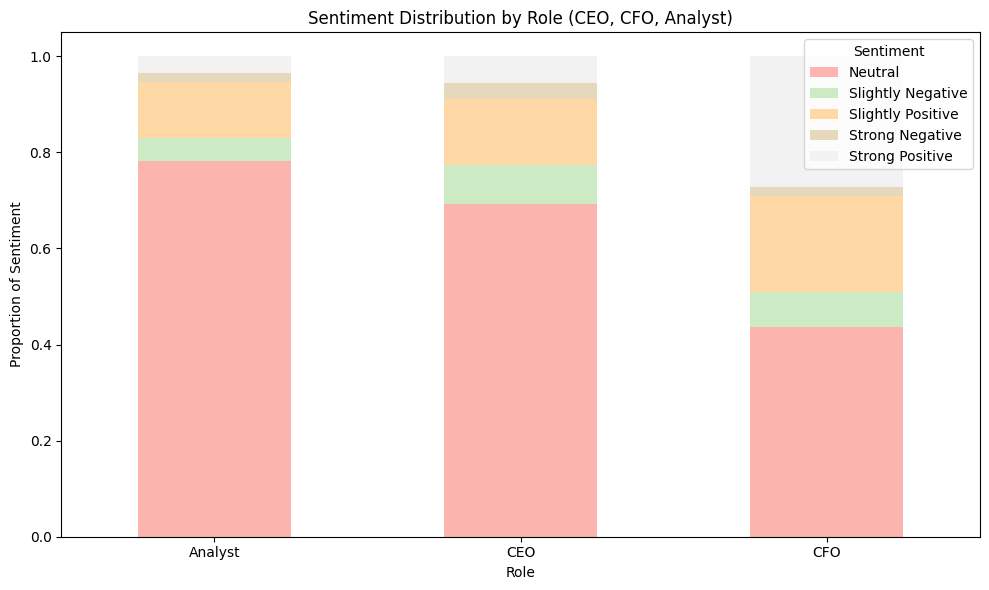

In [11]:
import matplotlib.pyplot as plt

# Load the FinBERT output
df = pd.read_csv("clean_transcripts/APPLE_finbert_output.csv")

# Map roles from job titles
def map_role(title):
    title = str(title).lower()
    if 'chief executive officer' in title or 'ceo' in title:
        return 'CEO'
    elif 'chief financial officer' in title or 'cfo' in title:
        return 'CFO'
    elif 'analyst' in title:
        return 'Analyst'
    else:
        return 'Other'

# Apply role mapping
df['role_category'] = df['title'].apply(map_role)

# Filter only CEO, CFO, Analyst roles
filtered_df = df[df['role_category'].isin(['CEO', 'CFO', 'Analyst'])]

# Group by role and sentiment category
role_sentiment_counts = filtered_df.groupby(['role_category', 'sentiment_category']).size().unstack(fill_value=0)

# Normalize to percentage
role_sentiment_percent = role_sentiment_counts.div(role_sentiment_counts.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
role_sentiment_percent.plot(kind='bar', stacked=True, colormap='Pastel1', figsize=(10, 6))

plt.title('Sentiment Distribution by Role (CEO, CFO, Analyst)')
plt.ylabel('Proportion of Sentiment')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


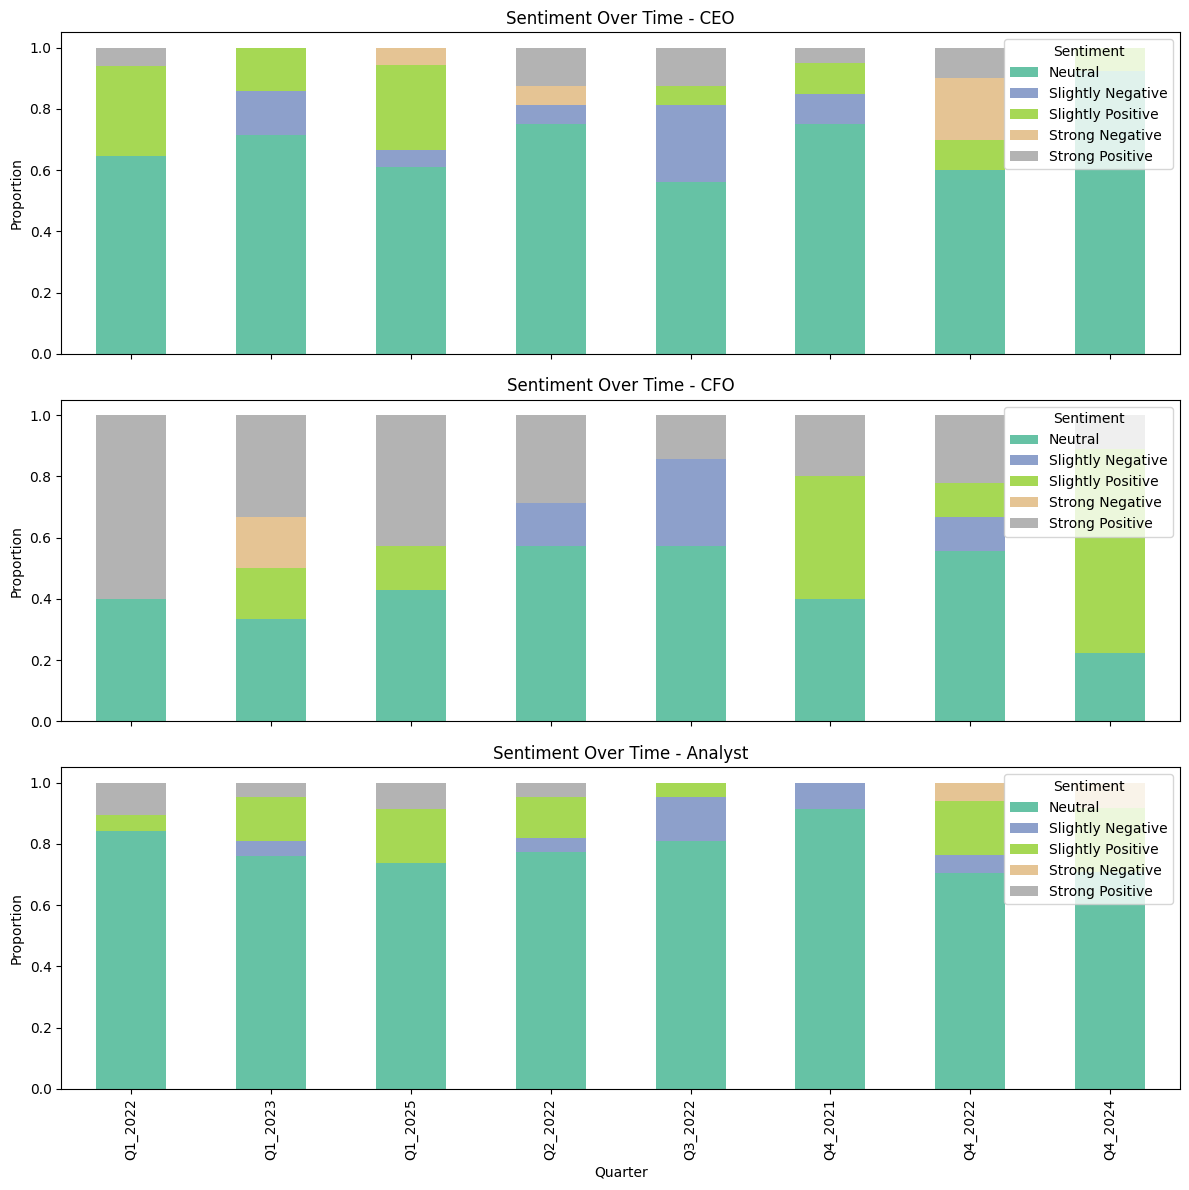

In [12]:
# Step 3: Group by quarter, role, sentiment category
temporal_counts = filtered_df.groupby(['quarter', 'role_category', 'sentiment_category']) \
                             .size().reset_index(name='count')

# Step 4: Normalize to get sentiment proportions
temporal_counts['total'] = temporal_counts.groupby(['quarter', 'role_category'])['count'].transform('sum')
temporal_counts['proportion'] = temporal_counts['count'] / temporal_counts['total']

# Step 5: Pivot table to create sentiment matrix
sentiment_table = temporal_counts.pivot_table(index=['quarter', 'role_category'],
                                              columns='sentiment_category',
                                              values='proportion',
                                              fill_value=0).reset_index()

# Optional: Save sentiment table to CSV
sentiment_table.to_csv("apple_role_sentiment_table.csv", index=False)

# Step 6: Plotting sentiment distribution over time by role
roles = ['CEO', 'CFO', 'Analyst']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

for i, role in enumerate(roles):
    role_data = sentiment_table[sentiment_table['role_category'] == role].set_index('quarter')
    role_data.drop(columns='role_category', inplace=True)
    
    role_data.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set2')
    axes[i].set_title(f'Sentiment Over Time - {role}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Sentiment', loc='upper right')

plt.xlabel('Quarter')
plt.tight_layout()
plt.show()


In [13]:
# Step 2: Function to generate summary table for any role
def get_sentiment_table_by_role(df, role_name):
    role_df = df[df['role_category'] == role_name]
    
    summary = role_df.groupby('quarter').agg({
        'sentiment_category': lambda x: ', '.join(sorted(set(x))),
        'confidence': 'mean'
    }).reset_index()
    
    summary['confidence'] = summary['confidence'].round(6)
    summary.insert(0, 'role', role_name)
    return summary

# Step 3: Generate tables for CEO, CFO, and Analyst
ceo_table = get_sentiment_table_by_role(df, 'CEO')
cfo_table = get_sentiment_table_by_role(df, 'CFO')
analyst_table = get_sentiment_table_by_role(df, 'Analyst')

# Optional: Save to CSV or display
# ceo_table.to_csv("ceo_sentiment_summary.csv", index=False)
# cfo_table.to_csv("cfo_sentiment_summary.csv", index=False)
# analyst_table.to_csv("analyst_sentiment_summary.csv", index=False)

# Display
print("CEO Sentiment Table:")
print(ceo_table.drop(columns='role'), '\n')

print("CFO Sentiment Table:")
print(cfo_table.drop(columns='role'), '\n')

print("Analyst Sentiment Table:")
print(analyst_table.drop(columns='role'))

CEO Sentiment Table:
   quarter                                 sentiment_category  confidence
0  Q1_2022        Neutral, Slightly Positive, Strong Positive    0.762180
1  Q1_2023      Neutral, Slightly Negative, Slightly Positive    0.728945
2  Q1_2025  Neutral, Slightly Negative, Slightly Positive,...    0.738268
3  Q2_2022  Neutral, Slightly Negative, Strong Negative, S...    0.800297
4  Q3_2022  Neutral, Slightly Negative, Slightly Positive,...    0.829187
5  Q4_2021  Neutral, Slightly Negative, Slightly Positive,...    0.767255
6  Q4_2022  Neutral, Slightly Positive, Strong Negative, S...    0.814419
7  Q4_2024                         Neutral, Slightly Positive    0.829166 

CFO Sentiment Table:
   quarter                                 sentiment_category  confidence
0  Q1_2022                           Neutral, Strong Positive    0.800592
1  Q1_2023  Neutral, Slightly Positive, Strong Negative, S...    0.818470
2  Q1_2025        Neutral, Slightly Positive, Strong Positive    0.8

In [14]:
#!pip install seaborn

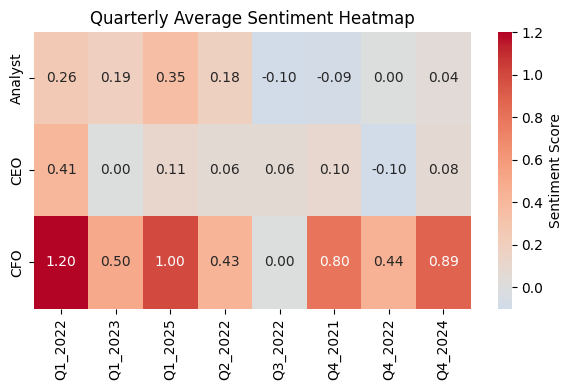

In [15]:
import seaborn as sns

# Map sentiment categories to numeric score
sentiment_map = {
    "Strong Positive": 2,
    "Slightly Positive": 1,
    "Neutral": 0,
    "Slightly Negative": -1,
    "Strong Negative": -2,
    "Uncertain": 0  # or np.nan to exclude
}
df['sentiment_score'] = df['sentiment_category'].map(sentiment_map)

# Group by quarter and role, compute average sentiment
pivot_df = df[df['role_category'].isin(['CEO', 'CFO', 'Analyst'])] \
    .groupby(['role_category', 'quarter'])['sentiment_score'] \
    .mean().unstack()

# Plot the heatmap
plt.figure(figsize=(6, 4))
ax = sns.heatmap(pivot_df, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                 cbar_kws={'label': 'Sentiment Score'})

plt.title("Quarterly Average Sentiment Heatmap")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Step 7: using LLMs to get sentiment score for each block

## API call

In [16]:
api_key = 'sk-58c0df73519c42debe27d41e164d455a'
base_url = "https://api.deepseek.com"
client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
seed = 42

## Getting the sentiment score for each blocks of text using an LLM.

In [17]:
df_llm = pd.read_csv("clean_transcripts/APPLE_finbert_output.csv")
df_llm = df_llm.reset_index(drop=False).rename(columns={"index":"id"})
payload = df_llm[["id","content"]].rename(columns={"content":"text"}).to_dict(orient="records")
# Make a fixed-size chunk generator
def chunk(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

# Define the prompt
system_prompt = """
You are a sentiment-analysis engine.
I will give you a JSON array of objects like:
  [ { "id": 0, "text": "…"}, { "id": 1, "text": "…"}, … ]

For each text, return a probability distribution over the five sentiment classes:
Strong Negative, Slightly Negative, Neutral, Slightly Positive, Strong Positive.
Label your columns:

id,
LLM_sentiment, 
LLM_pct_strong_positive,
LLM_pct_slightly_positive,
LLM_pct_neutral,
LLM_pct_slightly_negative,
LLM_pct_strong_negative

—with each LLM_pct_* a float from 0.0–1.0 summing to 1.0, one row per paragraph,
no markdown fences or commentary, pure CSV.
-for sentiment, choose one of the five classes. 
"""

# Function to run a batch of rows through the LLM
def run_batch(batch_rows):
    resp = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": json.dumps(batch_rows)}
        ],
        temperature=0.0,
        top_p=1.0
    )
    csv_str = resp.choices[0].message.content.strip()
    return pd.read_csv(io.StringIO(csv_str))

all_parts = []
for b in chunk(payload, 50):          # batches of 50 rows
    df_part = run_batch(b)            # call the LLM
    all_parts.append(df_part)

sent_df = pd.concat(all_parts, ignore_index=True)


## Merging with the original df

In [18]:
# Merge with the sentiment results
df_with_sentiment = df_llm.merge(
    sent_df,            # contains id, sentiment, pct_*
    on='id',            # join key
    how='left'          # keep every original row
)

df_with_sentiment.drop(columns=['id'], inplace=True)  # drop the id column

print(f"Successfully merged sentiment data for {len(df_with_sentiment)} rows")
df_with_sentiment.head()

Successfully merged sentiment data for 428 rows


,quarter,speaker,title,content,sentiment,confidence,sentiment_category,LLM_sentiment,LLM_pct_strong_positive,LLM_pct_slightly_positive,LLM_pct_neutral,LLM_pct_slightly_negative,LLM_pct_strong_negative
0,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Good afternoon, and welcome to the Apple Q1 fi...",neutral,0.942037,Neutral,Neutral,0.0,0.1,0.8,0.1,0.0
1,Q1_2025,Timothy Donald Cook,Chief Executive Officer,"Thank you, Suhasini. Good afternoon, everyone,...",neutral,0.868479,Neutral,Slightly Positive,0.1,0.5,0.3,0.1,0.0
2,Q1_2025,Kevan Parekh,"Senior Vice President, Chief Financial Officer","Thanks, Tim, and good afternoon, everyone. I'm...",positive,0.942901,Strong Positive,Slightly Positive,0.1,0.5,0.3,0.1,0.0
3,Q1_2025,Suhasini Chandramouli,"Director, Investor Relations","Thank you, Kevan. We ask that you limit yourse...",neutral,0.937472,Neutral,Neutral,0.0,0.1,0.8,0.1,0.0
4,Q1_2025,Erik Woodring,Analyst,"Great, guys. Thanks so much for taking my ques...",neutral,0.825077,Neutral,Neutral,0.0,0.2,0.7,0.1,0.0


In [19]:
#save df_with_sentiment to csv
output_path = 'clean_transcripts/APPLE_finbert_deepseek_output.csv'
df_with_sentiment.to_csv(output_path, index=False)
print(f"Saved sentiment output to {output_path}")

Saved sentiment output to clean_transcripts/APPLE_finbert_deepseek_output.csv


In [20]:
import pandas as pd

def clean_mf_junk_in_df(df, text_col="content"):
    df = df.copy()
    df[text_col] = df[text_col].astype(str).map(_demojibake_fix)
    mask_junk = df[text_col].str.contains(_MF_JUNK_RE, na=False)
    df = df.loc[~mask_junk].copy()
    df[text_col] = df[text_col].str.replace(r"\s+", " ", regex=True).str.strip()
    df = df[df[text_col].str.len() > 3].copy()
    return df.reset_index(drop=True)

# One-off cleanup of a saved file:
path = "clean_transcripts/APPLE_finbert_deepseek_output.csv"  # change as needed
df = pd.read_csv(path)
df_clean = clean_mf_junk_in_df(df, text_col="content")
out_path = path.replace(".csv", "_clean.csv")
df_clean.to_csv(out_path, index=False)
print(f"Removed {len(df)-len(df_clean)} junk rows. Saved: {out_path}")


Removed 0 junk rows. Saved: clean_transcripts/APPLE_finbert_deepseek_output_clean.csv


/var/folders/g0/lxfmpgzx1d9dfh29gsnfn3yh0000gn/T/ipykernel_29870/2411315321.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_junk = df[text_col].str.contains(_MF_JUNK_RE, na=False)


In [ ]:
APPLE_final = pd.read_csv("APPLE_full_output.csv")

# Select only the required columns
APPLE_final = APPLE_final[[
    "quarter",
    "content",
    "sentiment_category",
    "role_category",
    "LLM_sentiment",
    "Manual Annotation"
]]

# Rename columns
APPLE_final = APPLE_final.rename(columns={
    "sentiment_category": "FinBERT_sentiment",
    "Manual Annotation": "manual_annotation"
})

# Rearrange columns so role_category comes before FinBERT_sentiment
APPLE_final = APPLE_final[[
    "quarter",
    "content",
    "role_category",
    "FinBERT_sentiment",
    "LLM_sentiment",
    "manual_annotation"
]]

# Check the updated dataframe
print(APPLE_final)